# Initial Preprocessing

In [244]:
from pipeline import ModelPipeline

# Run model with all features
mp = ModelPipeline("/Users/zoe_mac/Desktop/EDA/subset_transactions2.csv")

# basic cleaning & features
mp.rename_columns()
mp.drop_duplicates()
mp.check_for_null()
mp.extract_currency_features()
mp.extract_time_features()
mp.cyclical_encoding()
mp.create_unique_ids()
mp.extract_additional_time_features()

# one‑hot encode only for some cols
mp.apply_one_hot_encoding(
    onehot_categorical_features=["sent_currency", "received_currency", "payment_type"]
)

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


# Train/Val/Test Split

In [245]:
# random_stratified or tempral
mp.split_train_test_val(split_type="temporal", test_size=0.15, val_size=0.15)

Keeping from_account_idx and to_account_idx (for merging node feats onto tabular data for Catboost)


(        day_cos       day_sin  edge_id  hour_of_day  is_weekend  \
 0          -1.0  1.224647e-16        0            0           0   
 1534       -1.0  1.224647e-16     1534            0           0   
 1533       -1.0  1.224647e-16     1533            0           0   
 1532       -1.0  1.224647e-16     1532            0           0   
 1531       -1.0  1.224647e-16     1531            0           0   
 ...         ...           ...      ...          ...         ...   
 875665     -0.5  8.660254e-01   875665           16           0   
 875664     -0.5  8.660254e-01   875664           16           0   
 875663     -0.5  8.660254e-01   875663           16           0   
 875662     -0.5  8.660254e-01   875662           16           0   
 875661     -0.5  8.660254e-01   875661           16           0   
 
         log_exchange_rate  payment_type_ACH  payment_type_Bitcoin  \
 0                0.693147               0.0                   0.0   
 1534             0.693147               0

# Calculate Graph-based Features

In [246]:
# 3) Compute node‐level graph features on each split
mp.compute_split_specific_node_features(
    graph_features=["sent_amount_usd"]
)

✅ Computed node features for train with 107090 nodes.
✅ Computed node features for val with 107355 nodes.
✅ Computed node features for test with 107583 nodes.


# Combine Node_features & Edge Features

In [247]:
X_train, X_val, X_test = mp.add_node_graph_feats_to_df()

# Drop Columns (some temporal features & account info)

In [248]:
drop = ['hour_of_day', 'is_weekend',
        'from_account_idx', 'to_account_idx',
        'edge_id','timestamp_int']

X_train.drop(drop, axis=1, inplace=True)
X_val.drop(drop, axis=1, inplace=True)
X_test.drop(drop, axis=1, inplace=True)

# Check with GNN

In [249]:
X_train # 67 cols

,day_cos,day_sin,log_exchange_rate,payment_type_ACH,payment_type_Bitcoin,payment_type_Cash,payment_type_Cheque,payment_type_Credit Card,payment_type_Reinvestment,payment_type_Wire,...,from_num_unique_in_partners,to_degree_centrality,to_pagerank,to_net_flow,to_avg_txn_out,to_avg_txn_in,to_std_txn_out,to_std_txn_in,to_num_unique_out_partners,to_num_unique_in_partners
0,-1.0,1.224647e-16,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,0.000056,0.000003,-5.630686e+07,8.052942e+05,2.180032e+06,5.098178e+05,2.818153e+06,2.0,4.0
1,-1.0,1.224647e-16,0.693147,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,0.000065,0.000003,5.508872e+04,2.244080e+03,3.242287e+03,2.403975e+03,7.200175e+03,4.0,3.0
2,-1.0,1.224647e-16,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.000028,0.000021,-1.676558e+07,9.635210e+04,1.211306e+06,1.354659e+05,1.104069e+06,1.0,2.0
3,-1.0,1.224647e-16,0.693147,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.000056,0.000002,3.949900e+05,3.386166e+04,3.863068e+03,2.278371e+04,4.249936e+03,2.0,4.0
4,-1.0,1.224647e-16,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.000037,0.000004,7.395933e+03,1.682090e+03,1.447124e+04,3.843996e+03,0.000000e+00,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875625,-0.5,8.660254e-01,0.693147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000065,0.000008,5.409743e+08,1.315695e+08,1.809583e+07,2.012013e+08,1.036452e+07,3.0,4.0
875626,-0.5,8.660254e-01,0.693147,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,0.000047,0.000016,-9.973113e+04,1.673657e+04,1.750077e+04,5.790274e+04,5.006839e+04,2.0,3.0
875627,-0.5,8.660254e-01,0.693147,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.000047,0.000019,-2.507015e+08,3.640795e+07,1.797319e+07,5.111040e+07,4.402205e+07,1.0,4.0
875628,-0.5,8.660254e-01,0.693147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.000028,0.000002,1.260162e+04,1.273378e+04,1.201464e+01,0.000000e+00,2.505573e+01,1.0,2.0


In [239]:
# as a list
# your columns
my_cols = X_train.columns.tolist()

# your friend’s columns (copy‑&‑paste their list here)
friend_cols = [
    'received_amount', 'sent_amount',
    'log_exchange_rate', 'sent_amount_usd',
    'timestamp_scaled', 'time_diff_from', 'time_diff_to',
    'turnaround_time', 'day_cos', 'day_sin', 'time_of_day_cos',
    'time_of_day_sin', 'received_currency_Australian Dollar',
    'received_currency_Bitcoin', 'received_currency_Brazil Real',
    'received_currency_Canadian Dollar', 'received_currency_Euro',
    'received_currency_Mexican Peso', 'received_currency_Ruble',
    'received_currency_Rupee', 'received_currency_Saudi Riyal',
    'received_currency_Shekel', 'received_currency_Swiss Franc',
    'received_currency_UK Pound', 'received_currency_US Dollar',
    'received_currency_Yen','received_currency_Yuan',
    'sent_currency_Australian Dollar',
    'sent_currency_Bitcoin', 'sent_currency_Brazil Real',
    'sent_currency_Canadian Dollar', 'sent_currency_Euro',
    'sent_currency_Mexican Peso', 'sent_currency_Ruble',
    'sent_currency_Rupee', 'sent_currency_Saudi Riyal',
    'sent_currency_Shekel', 'sent_currency_Swiss Franc',
    'sent_currency_UK Pound', 'sent_currency_US Dollar',
    'sent_currency_Yen',
    'sent_currency_Yuan', 'payment_type_ACH', 'payment_type_Bitcoin',
    'payment_type_Cash', 'payment_type_Cheque',
    'payment_type_Credit Card', 'payment_type_Reinvestment',
    'payment_type_Wire'
]

# compare as sets
print("Exact same columns?", set(my_cols) == set(friend_cols))

# what you have that they don’t
print("You have but they don’t:", sorted(set(my_cols) - set(friend_cols)))

# what they have that you don’t
print("They have but you don’t:", sorted(set(friend_cols) - set(my_cols)))

Exact same columns? False
You have but they don’t: ['from_avg_txn_in', 'from_avg_txn_out', 'from_degree_centrality', 'from_net_flow', 'from_num_unique_in_partners', 'from_num_unique_out_partners', 'from_pagerank', 'from_std_txn_in', 'from_std_txn_out', 'to_avg_txn_in', 'to_avg_txn_out', 'to_degree_centrality', 'to_net_flow', 'to_num_unique_in_partners', 'to_num_unique_out_partners', 'to_pagerank', 'to_std_txn_in', 'to_std_txn_out']
They have but you don’t: []


In [240]:
my_cols

['day_cos',
 'day_sin',
 'log_exchange_rate',
 'payment_type_ACH',
 'payment_type_Bitcoin',
 'payment_type_Cash',
 'payment_type_Cheque',
 'payment_type_Credit Card',
 'payment_type_Reinvestment',
 'payment_type_Wire',
 'received_amount',
 'received_currency_Australian Dollar',
 'received_currency_Bitcoin',
 'received_currency_Brazil Real',
 'received_currency_Canadian Dollar',
 'received_currency_Euro',
 'received_currency_Mexican Peso',
 'received_currency_Ruble',
 'received_currency_Rupee',
 'received_currency_Saudi Riyal',
 'received_currency_Shekel',
 'received_currency_Swiss Franc',
 'received_currency_UK Pound',
 'received_currency_US Dollar',
 'received_currency_Yen',
 'received_currency_Yuan',
 'sent_amount',
 'sent_amount_usd',
 'sent_currency_Australian Dollar',
 'sent_currency_Bitcoin',
 'sent_currency_Brazil Real',
 'sent_currency_Canadian Dollar',
 'sent_currency_Euro',
 'sent_currency_Mexican Peso',
 'sent_currency_Ruble',
 'sent_currency_Rupee',
 'sent_currency_Saudi Ri

In [250]:
l = sorted(set(my_cols) - set(friend_cols))
# edge features, to match should be 49
len(my_cols)-len(l)

49

# Run model with all features

Got some problem with Catboost...I think it's the package problem...as someone commented as well in the github

In [251]:
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score
)

# 1) Instantiate an XGBClassifier—mirror your CatBoost settings as closely as possible:
xgb_model = xgb.XGBClassifier(
    n_estimators= 500,        # iterations
    early_stopping_rounds=10,
    max_depth=10,             # your tuned depth
    learning_rate=0.1,        # your tuned learning rate
    objective='binary:logistic',
    scale_pos_weight=12,      # same class‐imbalance weight
    eval_metric='aucpr',      # PR‐AUC for early stopping
    random_state=42,
)

# 2) Fit with early stopping on your validation split:
xgb_model.fit(
    X_train, mp.y_train,
    eval_set=[(X_val, mp.y_val)],
    verbose=100
)

# 3) Get probabilities & 0.5‐threshold predictions:
train_proba = xgb_model.predict_proba(X_train)[:, 1]
val_proba   = xgb_model.predict_proba(X_val)[:, 1]
test_proba  = xgb_model.predict_proba(X_test)[:, 1]

train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

# 4) Print out PR-AUC on each split:
print(f"Train  PR-AUC: {average_precision_score(mp.y_train, train_proba):.4f}")
print(f"Valid  PR-AUC: {average_precision_score(mp.y_val,   val_proba):.4f}")
print(f"Test   PR-AUC: {average_precision_score(mp.y_test,  test_proba):.4f}")

# 5) And test‐set classification report + ROC-AUC:
print("\nTest Classification Report:")
print(classification_report(mp.y_test, test_pred))
print(f"Test ROC-AUC: {roc_auc_score(mp.y_test, test_proba):.4f}")

[0]	validation_0-aucpr:0.36897
[100]	validation_0-aucpr:0.66249
[141]	validation_0-aucpr:0.66562
Train  PR-AUC: 0.9895
Valid  PR-AUC: 0.6671
Test   PR-AUC: 0.8001

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186078
           1       0.79      0.70      0.74      1558

    accuracy                           1.00    187636
   macro avg       0.90      0.85      0.87    187636
weighted avg       1.00      1.00      1.00    187636

Test ROC-AUC: 0.9903


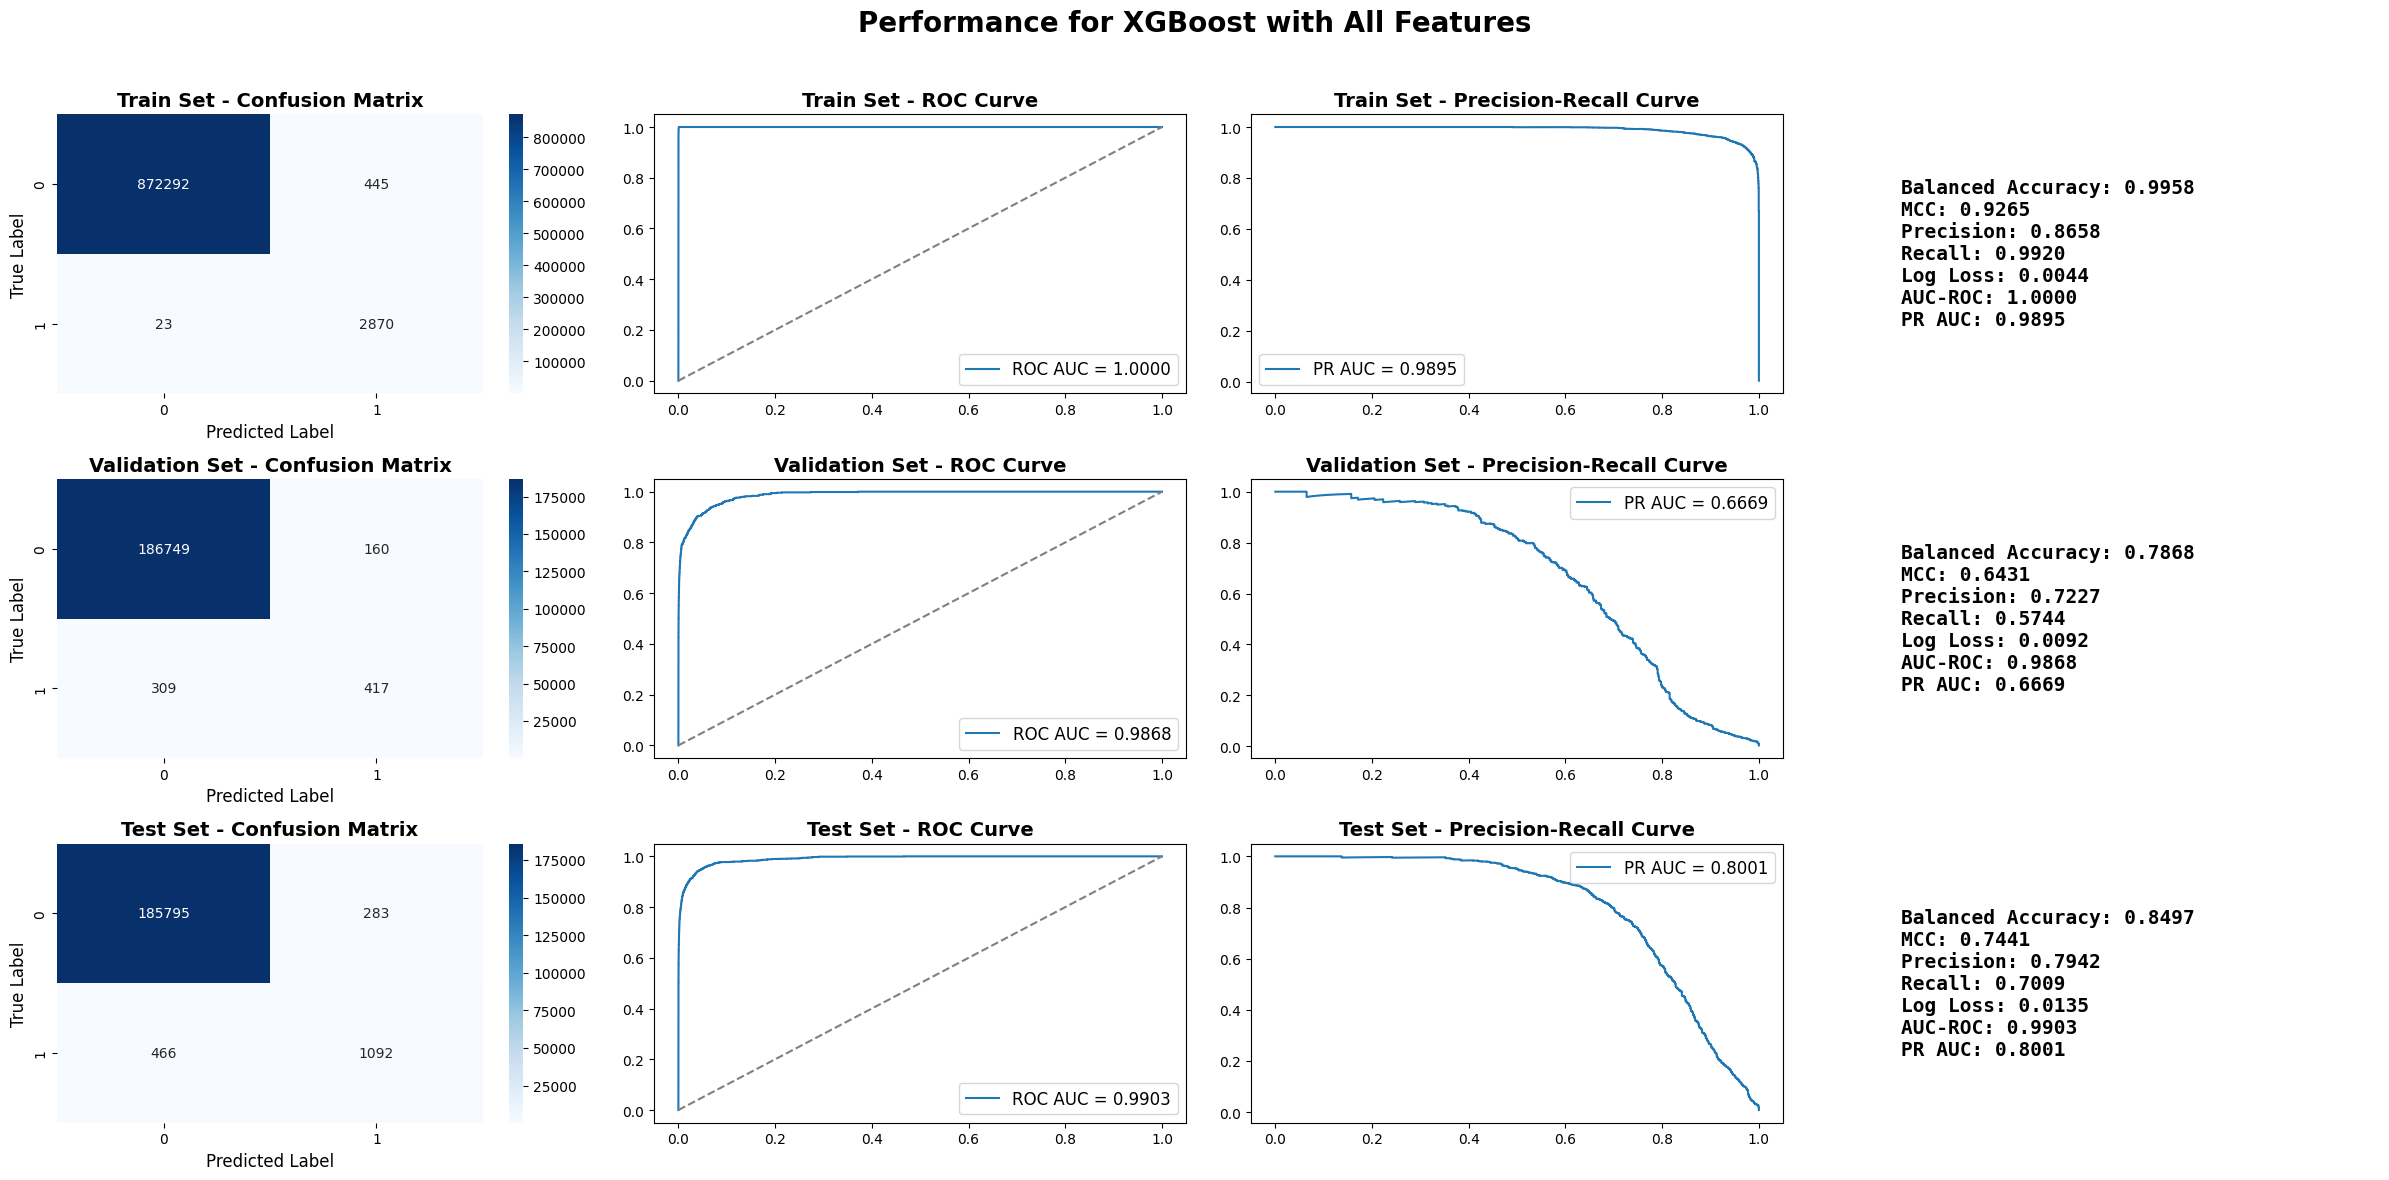

In [252]:
from plotting.result_metrics import result_metrics
# 6) Finally, re-use your 3×4 plotting helper:
slide_title = "Performance for XGBoost with All Features"
result_metrics(
    slide_title,
    mp.y_train, train_pred, train_proba,
    mp.y_val,   val_pred,   val_proba,
    mp.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)

# Rank Feature Importance

## Shap Value

In [211]:
import shap
import numpy as np
import pandas as pd

# 1. Create a SHAP explainer for your fitted XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 2. Compute SHAP values for your test set (matrix of shape [n_samples, n_features])
shap_values = explainer.shap_values(X_test)

# 3. Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 4. Build a ranking DataFrame
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print(shap_importance)

                       feature  mean_abs_shap
0             payment_type_ACH       1.823566
1       from_degree_centrality       1.073461
2               time_diff_from       0.537183
3              received_amount       0.320998
4   to_num_unique_out_partners       0.286025
..                         ...            ...
62          sent_currency_Yuan       0.000653
63   sent_currency_Swiss Franc       0.000296
64         sent_currency_Ruble       0.000213
65   received_currency_Bitcoin       0.000000
66       sent_currency_Bitcoin       0.000000

[67 rows x 2 columns]


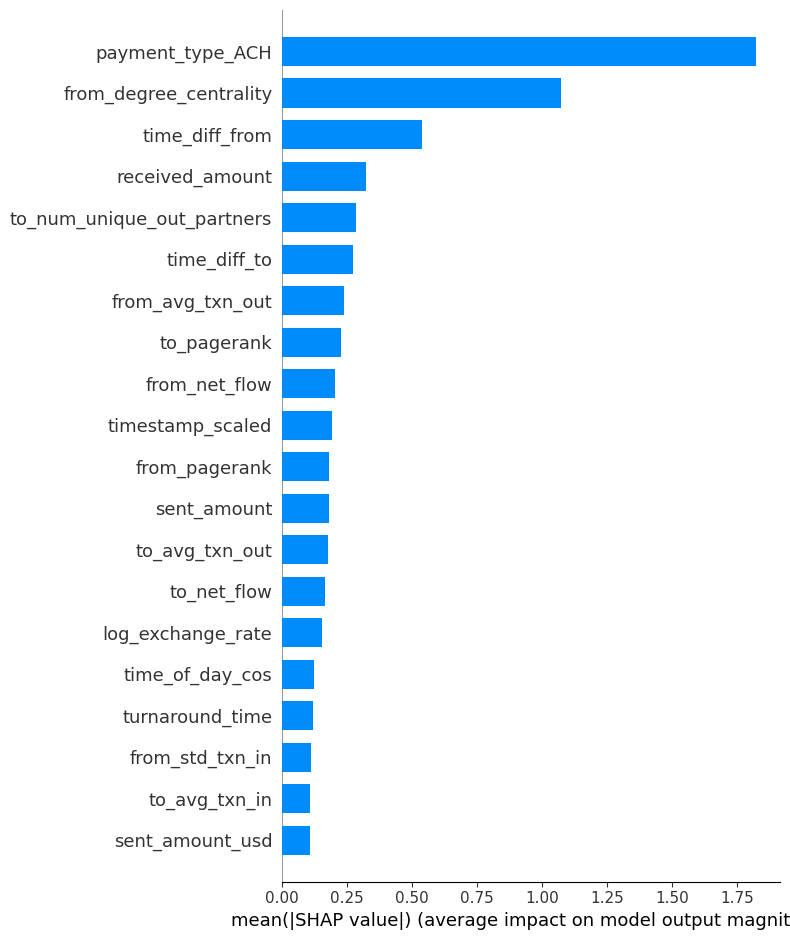

In [212]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type='bar',
    max_display=20  # show top 20 features
)

## Identify Top 3 ones

In [213]:
X = pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True)

In [215]:
# 2) Define your groups of interest
currency_features_sent     = [c for c in X.columns if c.startswith("sent_currency_")]
currency_features_received = [c for c in X.columns if c.startswith("received_currency_")]
payment_type_features      = [c for c in X.columns if c.startswith("payment_type_")]

# 3) Pull out top-3 in each
top3_sent     = (shap_importance[shap_importance['feature'].isin(currency_features_sent)]
                 .nlargest(3, 'mean_abs_shap'))
top3_received = (shap_importance[shap_importance['feature'].isin(currency_features_received)]
                 .nlargest(3, 'mean_abs_shap'))
top3_payment  = (shap_importance[shap_importance['feature'].isin(payment_type_features)]
                 .nlargest(3, 'mean_abs_shap'))

print("▶ Top 3 ‘currencies sent’ by |SHAP|:")
print(top3_sent.to_string(index=False))

print("\n▶ Top 3 ‘currencies received’ by |SHAP|:")
print(top3_received.to_string(index=False))

print("\n▶ Top 3 ‘payment types’ by |SHAP|:")
print(top3_payment.to_string(index=False))


▶ Top 3 ‘currencies sent’ by |SHAP|:
                  feature  mean_abs_shap
       sent_currency_Euro       0.034140
  sent_currency_US Dollar       0.012493
sent_currency_Saudi Riyal       0.009069

▶ Top 3 ‘currencies received’ by |SHAP|:
                      feature  mean_abs_shap
received_currency_Swiss Franc       0.011076
      received_currency_Ruble       0.010415
       received_currency_Euro       0.008234

▶ Top 3 ‘payment types’ by |SHAP|:
                 feature  mean_abs_shap
        payment_type_ACH       1.823566
payment_type_Credit Card       0.078120
     payment_type_Cheque       0.034436


In [216]:
X_train['sent_currency_other'] = (X_train[currency_features_sent].sum(axis=1) - X_train[top3_sent].sum(axis=1) > 0).astype(int)
X_train['received_currency_other'] = (X_train[currency_features_received].sum(axis=1) - X_train[top3_received].sum(axis=1) > 0).astype(int)
X_train['payment_type_other'] = (X_train[payment_type_features].sum(axis=1) - X_train[top3_payment].sum(axis=1) > 0).astype(int)

X_val['sent_currency_other'] = (X_val[currency_features_sent].sum(axis=1) - X_val[top3_sent].sum(axis=1) > 0).astype(int)
X_val['received_currency_other'] = (X_val[currency_features_received].sum(axis=1) - X_val[top3_received].sum(axis=1) > 0).astype(int)
X_val['payment_type_other'] = (X_val[payment_type_features].sum(axis=1) - X_val[top3_payment].sum(axis=1) > 0).astype(int)

X_test['sent_currency_other'] = (X_test[currency_features_sent].sum(axis=1) - X_test[top3_sent].sum(axis=1) > 0).astype(int)
X_test['received_currency_other'] = (X_test[currency_features_received].sum(axis=1) - X_test[top3_received].sum(axis=1) > 0).astype(int)
X_test['payment_type_other'] = (X_test[payment_type_features].sum(axis=1) - X_test[top3_payment].sum(axis=1) > 0).astype(int)

In [217]:
X['sent_currency_other'] = (X[currency_features_sent].sum(axis=1) - X[top3_sent].sum(axis=1) > 0).astype(int)
X['received_currency_other'] = (X[currency_features_received].sum(axis=1) - X[top3_received].sum(axis=1) > 0).astype(int)
X['payment_type_other'] = (X[payment_type_features].sum(axis=1) - X[top3_payment].sum(axis=1) > 0).astype(int)

In [218]:
len(X_train.columns.tolist())

70

In [219]:
# 5) Make sure all your “top3_*” variables are also plain Python lists of strings
top3_sent  = top3_sent['feature'].tolist()
top3_received = top3_received['feature'].tolist()
top3_payment  = top3_payment['feature'].tolist()

In [220]:
top3_sent

['sent_currency_Euro', 'sent_currency_US Dollar', 'sent_currency_Saudi Riyal']

# Stage 1: Group-based backward selection

In [222]:
from sklearn.metrics import f1_score, average_precision_score

# 2) Make everything a Python list before concatenating
all_cols = X_train.columns.tolist()

# 3) Build grouped_onehot as a set of strings
grouped_onehot = set(currency_features_sent
                     + currency_features_received
                     + payment_type_features)

# 4) Now safely slice it out
base_features = [c for c in all_cols if c not in grouped_onehot]

# 6) Define your feature_sets
feature_sets = {
    "all_onehots":        base_features + currency_features_sent   + currency_features_received + payment_type_features,
    "no_sent":            base_features + currency_features_received + payment_type_features,
    "no_received":        base_features + currency_features_sent     + payment_type_features,
    "no_currency":        base_features + payment_type_features,
    "top3_all":           base_features + top3_sent  + top3_received + top3_payment,
    "top3_payment_only":  base_features + currency_features_sent  + currency_features_received + top3_payment,
    #"top1_payment_only":  base_features + currency_features_sent + currency_features_received + ['payment_type_ACH','payment_type_other'],
}

def evaluate_feature_sets_xgb(X_train, y_train,
                              X_val, y_val, feature_sets):
    results = {}
    for name, feats in feature_sets.items():
        #print(feats)
        model = xgb.XGBClassifier(
            n_estimators= 500,        # iterations
            max_depth=10,             # your tuned depth
            learning_rate=0.1,        # your tuned learning rate
            objective='binary:logistic',
            scale_pos_weight=12,      # same class‐imbalance weight
            eval_metric='aucpr',      # PR‐AUC for early stopping
            random_state=42,
        )
        model.fit(X_train[feats], y_train)

        y_pred = model.predict(X_val[feats].astype(np.float32).values)
        y_prob = model.predict_proba(X_val[feats].astype(np.float32).values)[:,1]

        f1 = f1_score(y_val, y_pred)
        pr_auc = average_precision_score(y_val, y_prob)

        results[name] = {"F1": f1, "PR AUC": pr_auc}
        print(f"{name:12s} →  F1 = {f1:.4f},  PR-AUC = {pr_auc:.4f}")
    return results

# 7) And now the evaluation will work:
results = evaluate_feature_sets_xgb(
    X_train, mp.y_train,
    X_val,   mp.y_val,
    feature_sets
)

all_onehots  →  F1 = 0.6275,  PR-AUC = 0.6758
no_sent      →  F1 = 0.6343,  PR-AUC = 0.6849
no_received  →  F1 = 0.6262,  PR-AUC = 0.6781
no_currency  →  F1 = 0.6292,  PR-AUC = 0.6754
top3_all     →  F1 = 0.6295,  PR-AUC = 0.6771
top3_payment_only →  F1 = 0.6283,  PR-AUC = 0.6794


The best modle is no_sent.

# Stage 2: Backward selection on remaining features

Trying dropping from_std_txn_in: PR-AUC = 0.6865
✅ Removed from_std_txn_in; new best PR-AUC = 0.6865
Trying dropping received_currency_Australian Dollar: PR-AUC = 0.6867
✅ Removed received_currency_Australian Dollar; new best PR-AUC = 0.6867
Trying dropping payment_type_Cash: PR-AUC = 0.6874
✅ Removed payment_type_Cash; new best PR-AUC = 0.6874
Trying dropping from_std_txn_out: PR-AUC = 0.6901
✅ Removed from_std_txn_out; new best PR-AUC = 0.6901
Trying dropping time_of_day_sin: PR-AUC = 0.6909
✅ Removed time_of_day_sin; new best PR-AUC = 0.6909
Trying dropping from_degree_centrality: PR-AUC = 0.6927
✅ Removed from_degree_centrality; new best PR-AUC = 0.6927
Trying dropping sent_currency_other: PR-AUC = 0.6927
✅ Removed sent_currency_other; new best PR-AUC = 0.6927
Trying dropping received_currency_other: PR-AUC = 0.6927
✅ Removed received_currency_other; new best PR-AUC = 0.6927
Trying dropping payment_type_other: PR-AUC = 0.6927
✅ Removed payment_type_other; new best PR-AUC = 0.6927
T

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:11:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final test PR-AUC = 0.7660


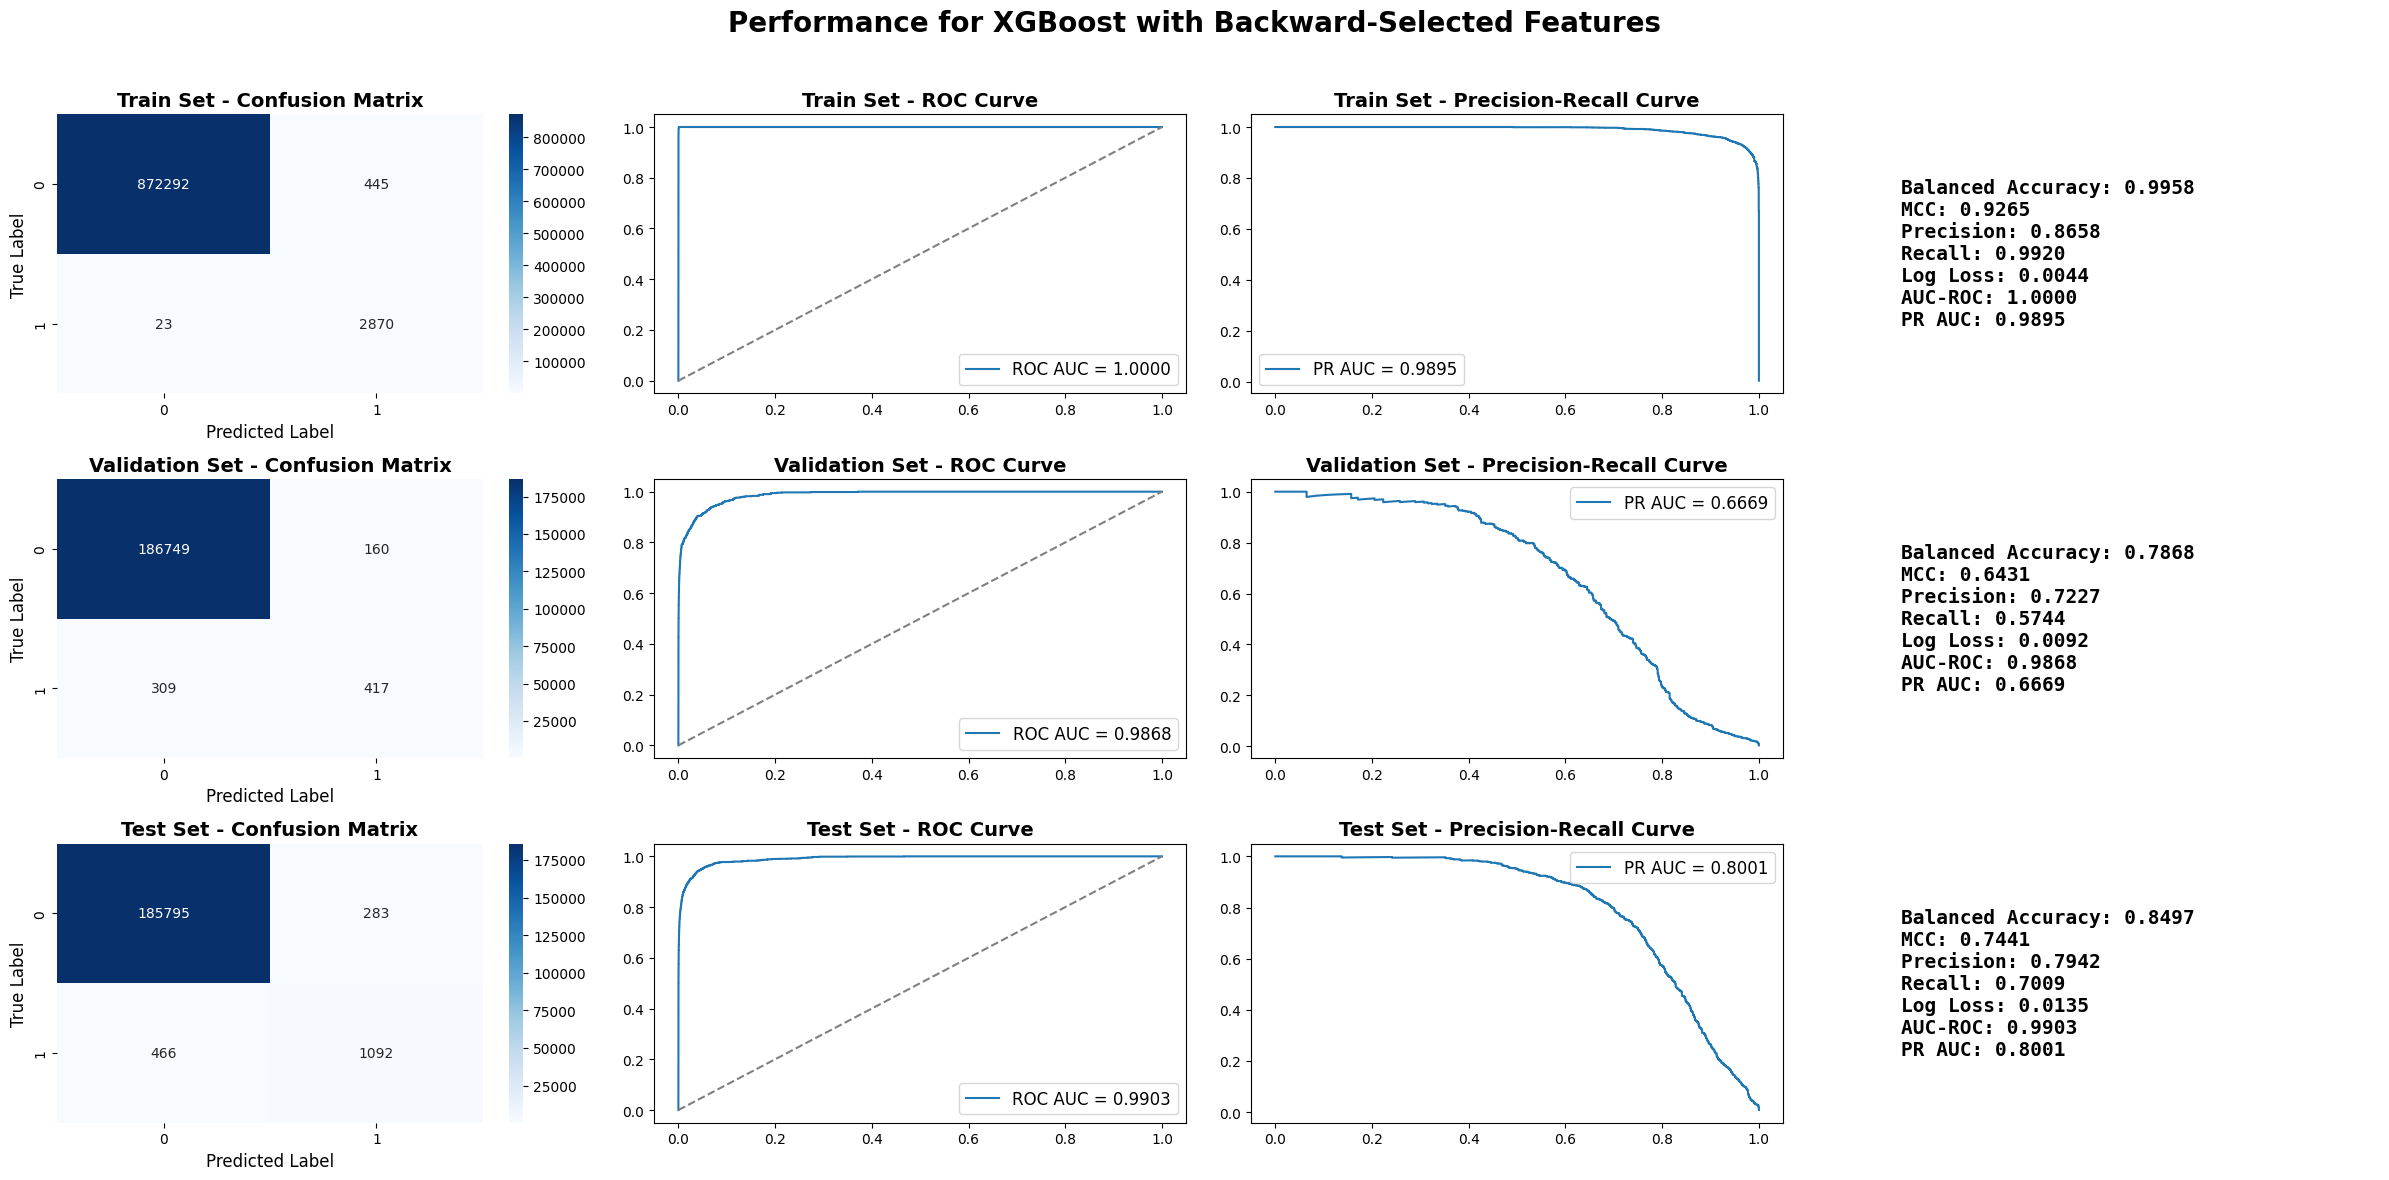

In [224]:
final_features = feature_sets["no_sent"]  # from previous evaluation

def backward_selection_xgb(
    X_train, y_train, X_val, y_val,
    features, min_features=10,
    random_state=42
):
    current_features = features.copy()
    best_score = 0.0
    best_features = current_features.copy()

    while len(current_features) > min_features:
        scores = {}
        for f in current_features:
            reduced = [feat for feat in current_features if feat != f]
            model = xgb.XGBClassifier(
                n_estimators= 500,        # iterations
                max_depth=10,             # tuned depth
                learning_rate=0.1,        # tuned learning rate
                objective='binary:logistic',
                scale_pos_weight=12,      # same class‐imbalance weight
                eval_metric='aucpr',      # PR‐AUC for early stopping
                random_state=42,
            )
            model.fit(
                X_train[reduced], y_train,
                # no early stopping here for speed; could add eval_set if you like
            )
            y_prob = model.predict_proba(X_val[reduced])[:, 1]
            scores[f] = average_precision_score(y_val, y_prob)

        # pick the removal that gives highest PR-AUC
        feature_to_remove = max(scores, key=lambda k: scores[k])
        score_after_removal = scores[feature_to_remove]
        print(f"Trying dropping {feature_to_remove}: PR-AUC = {score_after_removal:.4f}")

        if score_after_removal >= best_score:
            best_score = score_after_removal
            current_features.remove(feature_to_remove)
            best_features = current_features.copy()
            print(f"✅ Removed {feature_to_remove}; new best PR-AUC = {best_score:.4f}")
        else:
            print(f"🛑 Removal of {feature_to_remove} hurt performance. Stopping.")
            break

    return best_features

# Run backward selection:
selected_features = backward_selection_xgb(
    X_train, mp.y_train,
    X_val,   mp.y_val,
    final_features,
    min_features=10
)

print("→ Final feature set:", selected_features)

# Fit final XGB model on the reduced feature set:
final_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="aucpr",
    verbosity=1,
    random_state=42
)
final_model.fit(X_train[selected_features], mp.y_train)

# Evaluate on test set:
y_test_prob = final_model.predict_proba(X_test[selected_features])[:, 1]
y_test_pred = (y_test_prob > 0.5).astype(int)
test_pr_auc = average_precision_score(mp.y_test, y_test_prob)
print(f"Final test PR-AUC = {test_pr_auc:.4f}")

result_metrics(
    slide_title,
    mp.y_train, train_pred, train_proba,
    mp.y_val,   val_pred,   val_proba,
    mp.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)

# Final Model - Temporal Split

In [235]:
selected_features = ['day_cos', 'day_sin', 'log_exchange_rate', 'received_amount', 'sent_amount', 'sent_amount_usd', 'time_diff_from', 'time_diff_to', 'time_of_day_cos', 'timestamp_scaled', 'turnaround_time', 'from_pagerank', 'from_net_flow', 'from_avg_txn_out', 'from_avg_txn_in', 'from_num_unique_out_partners', 'from_num_unique_in_partners', 'to_degree_centrality', 'to_pagerank', 'to_net_flow', 'to_avg_txn_out', 'to_avg_txn_in', 'to_std_txn_out', 'to_std_txn_in', 'to_num_unique_out_partners', 'to_num_unique_in_partners', 'received_currency_Brazil Real', 'received_currency_Canadian Dollar', 'received_currency_Euro', 'received_currency_Mexican Peso', 'received_currency_Ruble', 'received_currency_Rupee', 'received_currency_Saudi Riyal', 'received_currency_Shekel', 'received_currency_Swiss Franc', 'received_currency_UK Pound', 'received_currency_US Dollar', 'received_currency_Yen', 'received_currency_Yuan', 'payment_type_ACH', 'payment_type_Cheque', 'payment_type_Credit Card', 'payment_type_Reinvestment', 'payment_type_Wire']

[0]	validation_0-aucpr:0.36417
[100]	validation_0-aucpr:0.66102
[200]	validation_0-aucpr:0.67733
[300]	validation_0-aucpr:0.68517
[400]	validation_0-aucpr:0.69035
[499]	validation_0-aucpr:0.69259


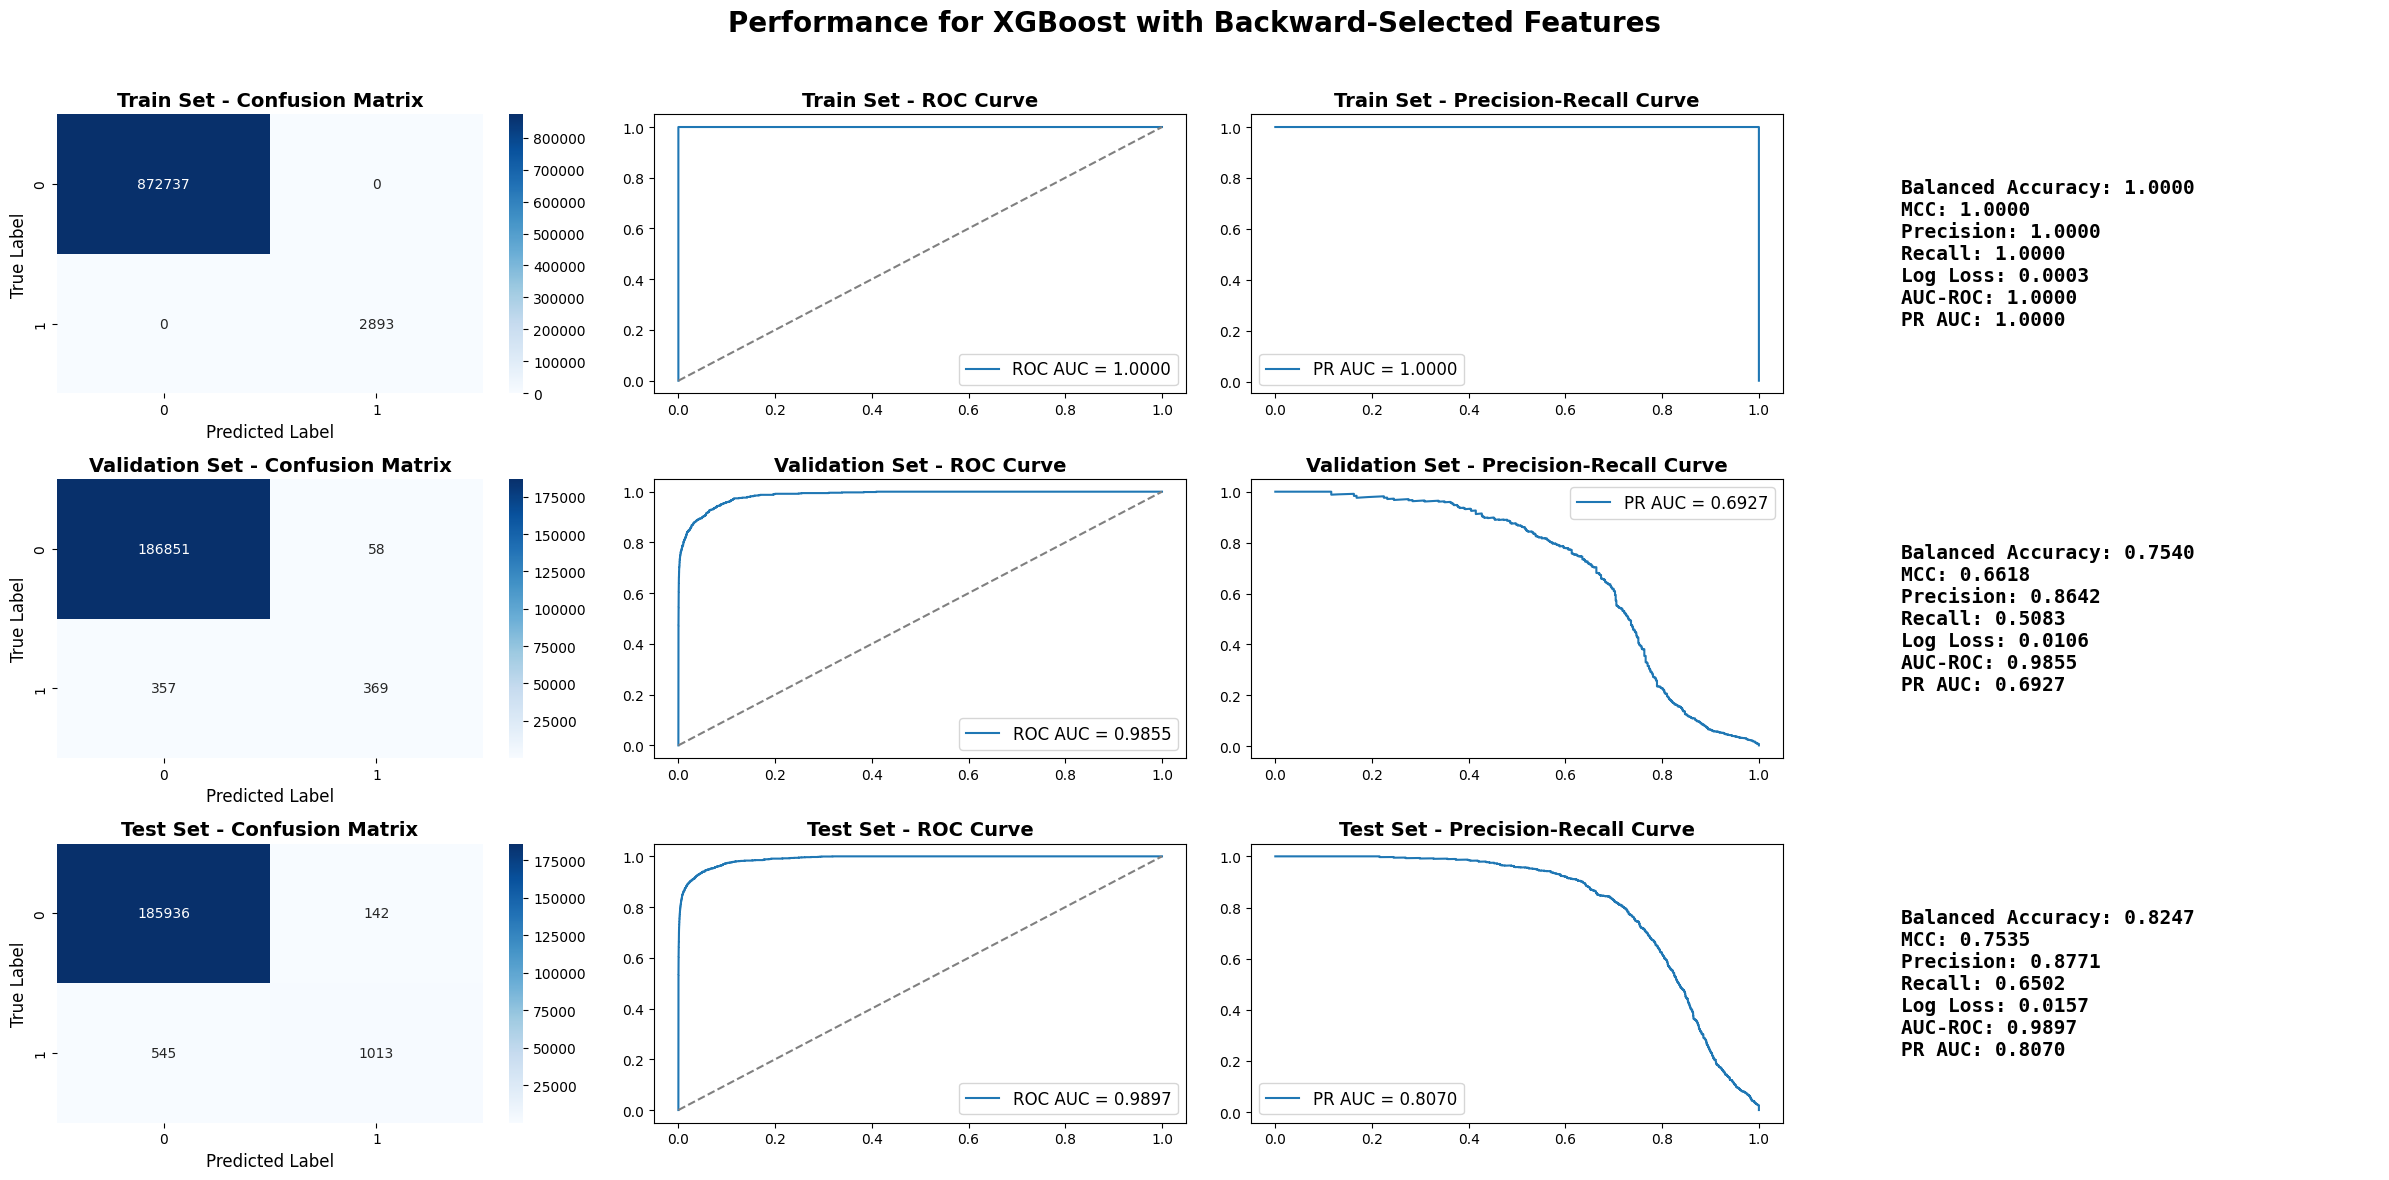

In [255]:
# 1) Instantiate an XGBClassifier—mirror your CatBoost settings as closely as possible:
xgb_model = xgb.XGBClassifier(
    n_estimators= 500,        # iterations
    early_stopping_rounds=50,
    max_depth=10,             # your tuned depth
    learning_rate=0.1,        # your tuned learning rate
    objective='binary:logistic',
    scale_pos_weight=12,      # same class‐imbalance weight
    eval_metric='aucpr',      # PR‐AUC for early stopping
    random_state=42,
)

# 2) Fit with early stopping on your validation split:
xgb_model.fit(
    X_train[selected_features], mp.y_train,
    eval_set=[(X_val[selected_features], mp.y_val)],
    verbose=100
)

# 3) Get probabilities & 0.5‐threshold predictions:
train_proba = xgb_model.predict_proba(X_train[selected_features])[:, 1]
val_proba   = xgb_model.predict_proba(X_val[selected_features])[:, 1]
test_proba  = xgb_model.predict_proba(X_test[selected_features])[:, 1]

train_pred = (train_proba > 0.5).astype(int)
val_pred   = (val_proba   > 0.5).astype(int)
test_pred  = (test_proba  > 0.5).astype(int)

slide_title = "Performance for XGBoost with Backward-Selected Features"
result_metrics(
    slide_title,
    mp.y_train, train_pred, train_proba,
    mp.y_val,   val_pred,   val_proba,
    mp.y_test,  test_pred,  test_proba,
    class_labels=["Licit", "Illicit"]
)

In [254]:
len(X_train[selected_features].columns.tolist())

44

# SHAP for Final Importance Check

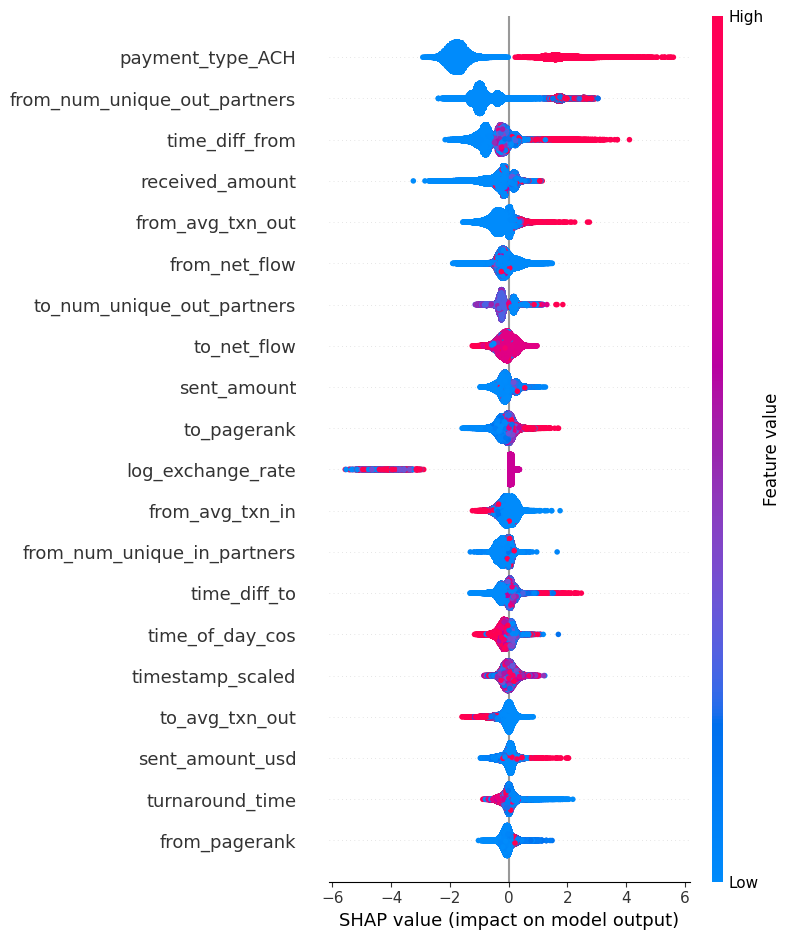

In [225]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val[selected_features])

# Plot SHAP summary
shap.summary_plot(shap_values, X_val[selected_features])

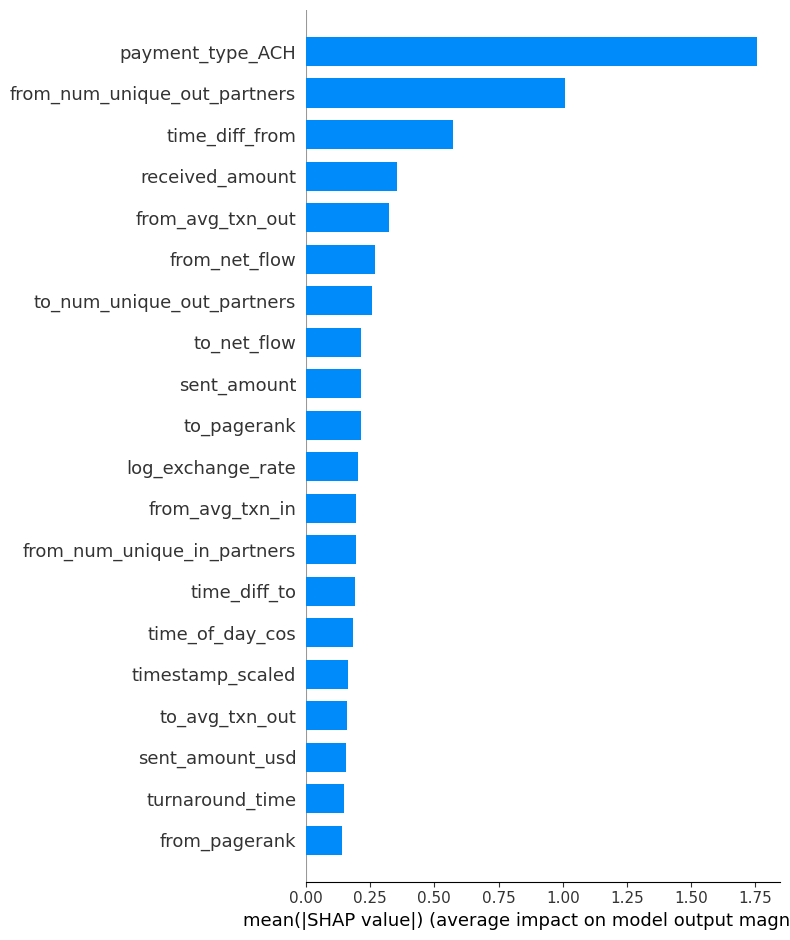

In [227]:
shap.summary_plot(
    shap_values,
    X_val[selected_features],
    plot_type='bar',
    max_display=20  # show top 20 features
)